<h1>Prompt Image Matching Process</h1>

In [1]:
import pandas as pd

tagged_sample_df = pd.read_csv('datasets/gpt2_florence_sample_dataset_tagged_2025_02_19_18_32_58.csv')
tagged_sample_df.head()

file_name  \
0  5dec6d6e40bd4d6bb3016f05bef8c3ae.jpg   
1  5104d2b1073347a7acf5a7cc0d5e1d19.jpg   
2  f73e688021f04f128db6f1f399244d9b.jpg   
3  20c657d94d5b4993a2e04879c8bdcf0d.jpg   
4  7defda9553cd45c0aecad952d6eb8fa0.jpg   

                                     tagging_vitgpt2  \
0              a baby sitting on a table with a toy    
1        a woman holding a red and white teddy bear    
2          a pink rose in a white vase with flowers    
3       a young woman standing next to a young girl    
4  a table with a bunch of different colored flow...   

                                      florence_short  \
0  A baby sitting on the floor playing with color...   
1   A woman in a red scarf and mittens blowing snow.   
2  A circle of pink roses with green leaves and r...   
3  A woman in a red dress holding hands with a ma...   
4  A bunch of yellow and red tulips next to an ea...   

                                       florence_long  
0  The image shows a baby sitting on the floor wi...  
1  The image shows a young woman with long brown ...  
2  The image is a flat lay of a wreath made of pi...  
3  The image shows a young woman and a young man ...  
4  The image is a flat lay of colorful Easter egg...

<h2>Labelled Images</h2>

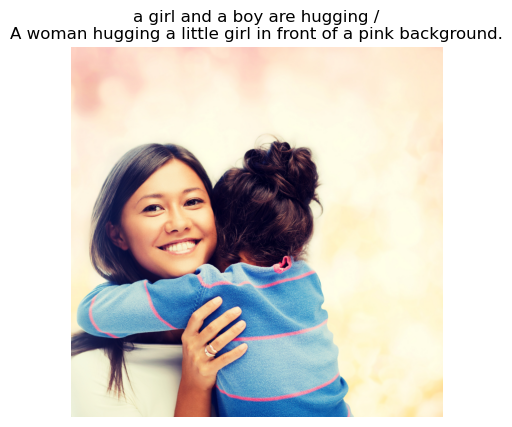

In [2]:
id = 169
image_name = tagged_sample_df.iloc[id].file_name
image_tag = tagged_sample_df.iloc[id].tagging_vitgpt2 + "/\n"+ tagged_sample_df.iloc[id].florence_short
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_filename = '../sample_imagesv2/'+image_name
#image_filename = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
img = mpimg.imread(image_filename)
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.title(image_tag)
plt.show()

<h2>Text Preprocessing </h2>

In [3]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#print(lemmatizer.lemmatize("cats"))


def text_preprocess(text_in):
    stopwords_ = stopwords.words('english')
    stopwords_.append('image')

    pattern = r'[^a-zA-Z.,?\s]' #find unwanted characters (non-alphanumeric and non-whitespace)
    clean_text = re.sub(pattern, ' ', text_in.lower())#replace them with an empty string
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    word_list = word_tokenize(clean_text)
    word_list = [word for word in word_list if word not in stopwords_]
    
    Nw = len(word_list)#number of words
    
    lemmatizer = WordNetLemmatizer()
    #stemmer = SnowballStemmer('english') #english stemmer
    for i in range(Nw):
        word = word_list[i]
        #word = stemmer.stem(word)
        word = lemmatizer.lemmatize(word)
        word_list[i] = word
    
    clean_text = ' '.join(word_list)
    return clean_text
    

In [4]:
id = 10
text_in = tagged_sample_df.iloc[id].florence_long
print(text_in,'\n\n',text_preprocess(text_in))

In this image, we can see a young man working on a wall. He is wearing
a green t-shirt and white gloves and is holding a trowel in his right
hand. He appears to be in the process of applying plaster to the wall.
The wall is made of concrete and there is a window on the left side of
the image. The man is standing on a ladder and is focused on his work.
The image is taken from a low angle, looking up at the wall and the
man. 

 , see young man working wall . wearing green shirt white glove holding trowel right hand . appears process applying plaster wall . wall made concrete window left side . man standing ladder focused work . taken low angle , looking wall man .


<h3>Feature formation</h3>

In [5]:
tagged_sample_df['features'] = tagged_sample_df['florence_long'].apply(text_preprocess)

tagged_sample_df[['features']].head()

features
0  show baby sitting floor big smile face . baby ...
1  show young woman long brown hair , wearing red...
2  flat lay wreath made pink rose . rose arranged...
3  show young woman young man walking hand hand p...
4  flat lay colorful easter egg tulip white backg...

<h2>TFIDF Computation</h2>

In [6]:
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np

tfidf = TfidfVectorizer(stop_words='english') #Term Frequency Matrix  max_features=n_feats
X = tfidf.fit_transform(tagged_sample_df['features']).toarray()
X.shape #get feature matrix size

(500, 1757)

<h2>Text Matching Algorithm - Word2Vec</h2>

<h3>Pre-training Word Embedders</h3>

In [7]:
#https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.html
import gensim.downloader
# Show all available models in gensim-data
gensim_pretrains = list(gensim.downloader.info()['models'].keys())

N = len(gensim_pretrains)
for i in range(N):
    pretrain_model_name = gensim_pretrains[i]
    print("[",i+1,"] ", pretrain_model_name)

[ 1 ]  fasttext-wiki-news-subwords-300
[ 2 ]  conceptnet-numberbatch-17-06-300
[ 3 ]  word2vec-ruscorpora-300
[ 4 ]  word2vec-google-news-300
[ 5 ]  glove-wiki-gigaword-50
[ 6 ]  glove-wiki-gigaword-100
[ 7 ]  glove-wiki-gigaword-200
[ 8 ]  glove-wiki-gigaword-300
[ 9 ]  glove-twitter-25
[ 10 ]  glove-twitter-50
[ 11 ]  glove-twitter-100
[ 12 ]  glove-twitter-200
[ 13 ]  __testing_word2vec-matrix-synopsis


<h3>Google Word2Vec Word Embedding</h3>

In [8]:
model_i = 4 #ruscorpora(deja), glove-twitter-25 (deja), word2vec-google-news-300 (deja)
pretrain_model_name = gensim_pretrains[model_i-1]
word2vec_model = gensim.downloader.load(pretrain_model_name)


In [9]:
word_text = 'people'
text_vec = word2vec_model[word_text]
print('Vector representation of %s :(%d x 1)'%(text_in,text_vec.shape[0]))
print(text_vec)

Vector representation of In this image, we can see a young man working on a wall. He is wearing
a green t-shirt and white gloves and is holding a trowel in his right
hand. He appears to be in the process of applying plaster to the wall.
The wall is made of concrete and there is a window on the left side of
the image. The man is standing on a ladder and is focused on his work.
The image is taken from a low angle, looking up at the wall and the
man. :(300 x 1)
[ 0.26367188 -0.01916504  0.02893066  0.234375   -0.00787354  0.01635742
 -0.11279297  0.06640625  0.0015564  -0.0402832  -0.0246582  -0.11523438
 -0.05615234 -0.05126953 -0.11621094  0.05053711 -0.09277344  0.16113281
 -0.10498047  0.07958984 -0.125      -0.04711914  0.14257812 -0.17578125
  0.00460815 -0.15136719 -0.11621094  0.07470703  0.05932617 -0.21289062
 -0.08544922  0.21582031 -0.28515625  0.08349609 -0.02124023  0.1171875
 -0.09814453 -0.02185059 -0.17089844  0.21972656  0.01916504 -0.06982422
  0.11474609 -0.08300781  0

<h3>Semantic Rationale</h3>

In [10]:
from sklearn.metrics.pairwise import cosine_similarity 

word1 = 'car'
word2 = 'truck'

word2vec_1 = word2vec_model[word1].reshape(1,-1)
word2vec_2 = word2vec_model[word2].reshape(1,-1)

w2v_cosine_similarity = cosine_similarity(word2vec_1,word2vec_2)
print(f'{word1} vs {word2} = {w2v_cosine_similarity[0][0]}')

car vs truck = 0.6735790371894836


In [11]:
#Save results
from datetime import datetime
# Get the current date and time
now = datetime.now()
timestamp_str = now.strftime('%Y_%m_%d_%H_%M_%S')
print(timestamp_str)

2025_02_22_13_41_55


In [12]:
features = tfidf.get_feature_names_out().tolist()
features[0]

'abandonment'

<h3>Corpus Word Embedding Formation</h3>

In [13]:
import numpy as np
#X
features = tfidf.get_feature_names_out().tolist()
Nf = len(features)
word_embeddings = {}
ei = 0
for i in range(Nf):
    feature = features[i]  
    if feature in word2vec_model:
        word_embeddings[feature] = word2vec_model[feature].reshape(1,-1)
    else:
        word_embeddings[feature] = np.zeros(word2vec_model.vector_size).reshape(1,-1)
        ei+=1
        print(ei, "missing-->",feature)
    #print(i)
word_embeddings['abandonment']

1 missing--> baubs
2 missing--> dente
3 missing--> glamour
4 missing--> grey
5 missing--> labelled
6 missing--> monstera
7 missing--> orangents
8 missing--> selfie
9 missing--> yosemite


array([[ 0.0144043 ,  0.08984375,  0.13574219, -0.07421875, -0.18457031,
         0.06884766,  0.01916504, -0.13476562,  0.23339844,  0.08935547,
        -0.06640625, -0.06933594, -0.10449219,  0.30859375, -0.09033203,
         0.05810547,  0.06494141, -0.16308594, -0.21875   , -0.07910156,
         0.11523438, -0.28515625, -0.06933594,  0.04272461, -0.01501465,
         0.20117188, -0.05395508,  0.20214844,  0.19238281, -0.17089844,
         0.10742188, -0.12988281, -0.29296875, -0.01745605, -0.16308594,
         0.140625  ,  0.11962891,  0.05664062,  0.06640625, -0.1953125 ,
         0.11865234,  0.13378906,  0.09716797, -0.19042969, -0.15136719,
        -0.26953125,  0.05908203,  0.17578125, -0.07226562, -0.1484375 ,
         0.03271484,  0.171875  , -0.41992188,  0.03344727,  0.20214844,
         0.06884766, -0.32421875, -0.13085938,  0.07568359,  0.00291443,
        -0.09716797, -0.00643921, -0.04931641, -0.15722656, -0.10986328,
        -0.27539062, -0.0324707 ,  0.13769531, -0.2

<h3>Record Word Embedding - TFIDF Weighted Average </h3>

In [16]:
X_emb = np.zeros((X.shape[0],word2vec_model.vector_size))

for i in range(X_emb.shape[0]):
    for j in range(Nf):
        vec = word_embeddings[features[j]]*X[i][j]   
        X_emb[i] +=  vec.reshape(-1,)
    X_emb[i] /= np.sum(X[i])

X_emb

array([[ 0.03208293,  0.06966787,  0.02034273, ...,  0.06951584,
        -0.0402649 , -0.01855265],
       [ 0.05738811,  0.06200853, -0.01388709, ...,  0.0543396 ,
         0.05303511, -0.00099789],
       [ 0.00978749,  0.09041081, -0.01838535, ..., -0.04098519,
         0.08259568,  0.07983476],
       ...,
       [ 0.0421574 ,  0.01381224,  0.01032854, ..., -0.08802628,
         0.00439303,  0.03765728],
       [ 0.10739903,  0.05297294,  0.00933441, ..., -0.05212534,
         0.03424713, -0.04500068],
       [-0.01497607,  0.0878928 , -0.01796675, ..., -0.08045266,
         0.06683799, -0.01905152]])

In [17]:
X_text = tfidf.transform([text])
X_text.shape

(1, 1757)

<h3>Text to Sentence Embedding </h3>

In [18]:
def text2emb(text_in):
    text_out = text_preprocess(text_in)
    pattern = r'[^a-zA-Z\s]' #find unwanted characters (non-alphanumeric and non-whitespace)
    clean_text = re.sub(pattern, ' ', text_out.lower())#replace them with an empty string
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    word_list = word_tokenize(clean_text)
    N_w = len(word_list)
    
    text_emb = np.zeros((1,word2vec_model.vector_size))
    
    for i in range(N_w):
        feature = word_list[i]
        if feature in word2vec_model:
            vec = word2vec_model[feature].reshape(1,-1)
        else:
            vec = np.zeros(word2vec_model.vector_size).reshape(1,-1)
            
        text_emb += vec
        
    if N_w == 0:
        N_w = 1
    text_emb /= N_w
    
    return text_emb
    

<h3>Text Query Image Recommender</h3>

In [27]:
def wordemb_image_recommender(tagged_sample_df_,tagger,tf_idf,X_emb_matrix,text,text2emb_,thr_=0.35,top_n=10):
    """
    X_text = tf_idf.transform([text])
    X_emb_text = np.zeros((1,word2vec_model.vector_size))#make dynamic
    for j in range(Nf):
        vec = word_embeddings[features[j]]*X_text[0][j]   
        X_emb_text[0] +=  vec.reshape(-1,)
    X_emb_text[i] /= np.sum(X[i])
    """
    X_emb_text = text2emb_(text)
    
    cosine_sim_matrix = cosine_similarity(X_emb_text,X_emb_matrix)
    cosine_sim_matrix = cosine_sim_matrix[0]
    sort_ids = np.argsort(cosine_sim_matrix)#sort 
    sort_ids = sort_ids[::-1]#descendingly
    features_df_rec = tagged_sample_df_.loc[sort_ids,['file_name',tagger]]
    features_df_rec['sim'] = cosine_sim_matrix[sort_ids]
    output_df_ = features_df_rec[features_df_rec['sim'] > thr_]
    output_df = output_df_.iloc[0:top_n,:]
    return output_df 

<h3> Testing Sentence Query Image Recommendation</h3>

In [33]:
import time

text = 'careers in engineering'
text_in = text_preprocess(text)
top_k = 10
sensitivity_thr = 0.0
tagger = 'florence_long'

tic = time.time()
word_emb_output_df = wordemb_image_recommender(tagged_sample_df,tagger,[],X_emb,text_in,text2emb,thr_=sensitivity_thr,top_n=top_k)
toc = time.time()
# Print elapsed time
print(f"Execution Time: {toc - tic:.4f} seconds")

Execution Time: 0.1186 seconds


In [34]:
word_emb_output_df

file_name  \
438  f13833ff278b4b70b0e7c2f7eeeea87b.jpg   
395  f9e5a776df4c44a4a4aad1770e676908.jpg   
10   d09e8246e2354d64acc014ba08f1bc46.jpg   
351  714da92a2613431c8b87afaa064dc6d9.jpg   
317  cf7d881dcc5547f5832ebb85063b44d9.jpg   
20   d14c4e6c44cf463cb77a6954091b6959.jpg   
91   7dc9c33a12de4d099df391f9038cb4d3.jpg   
69   aa8b7064b31948efb5994de2f96d9da7.jpg   
114  2c0280d40e2a4ab2bbf083115318afe0.jpg   
392  482b14f356444a46a0dafaecff27d1f4.jpg   

                                         florence_long       sim  
438  The image is a digital rendering of a modern s...  0.323765  
395  The image shows a man wearing a yellow hard ha...  0.309961  
10   In this image, we can see a young man working ...  0.298787  
351  The image shows a group of nine business peopl...  0.289640  
317  The image shows a young woman sitting on a met...  0.276095  
20   The image shows a group of students sitting at...  0.270583  
91   The image shows a construction worker in a lar...  0.266957  
69   The image shows a construction site with a tal...  0.263355  
114  The image shows three men in an office setting...  0.260721  
392  The image is a close-up of a tall skyscraper w...  0.255149

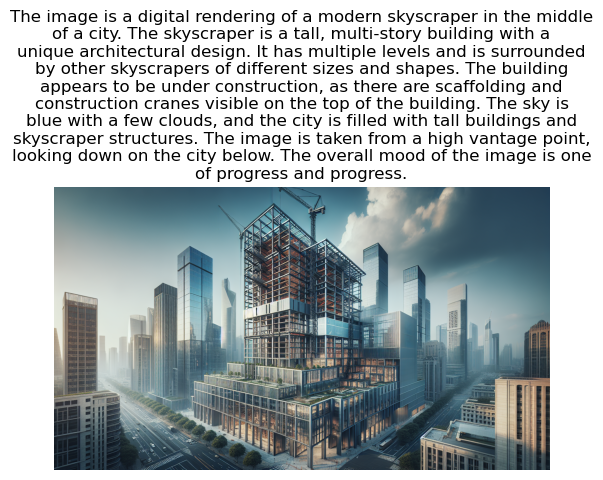

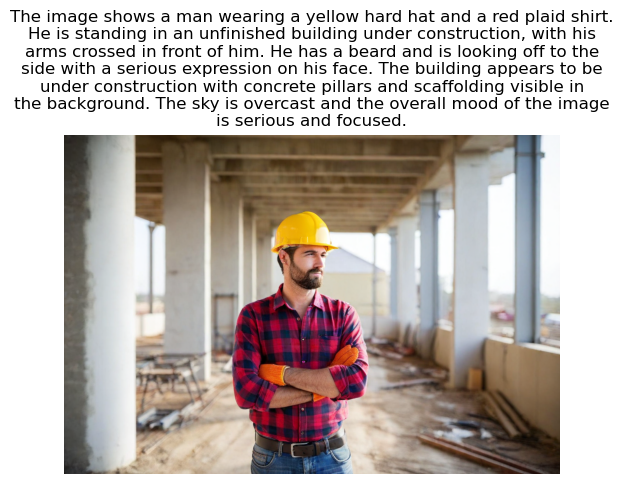

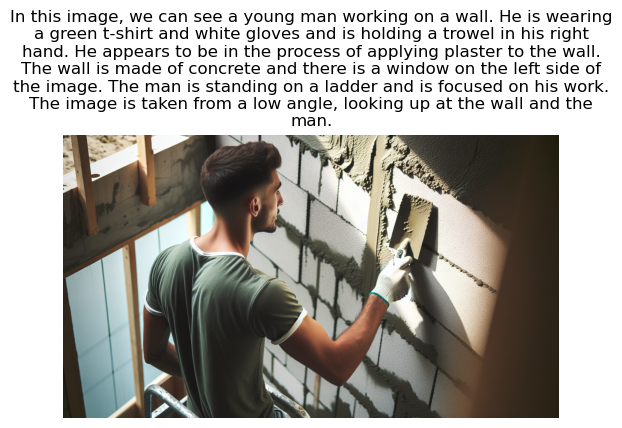

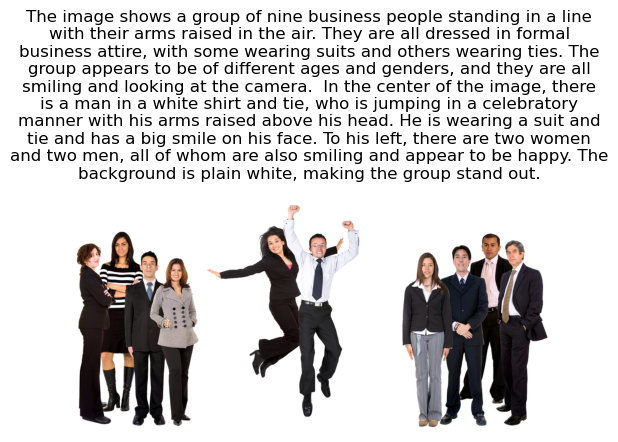

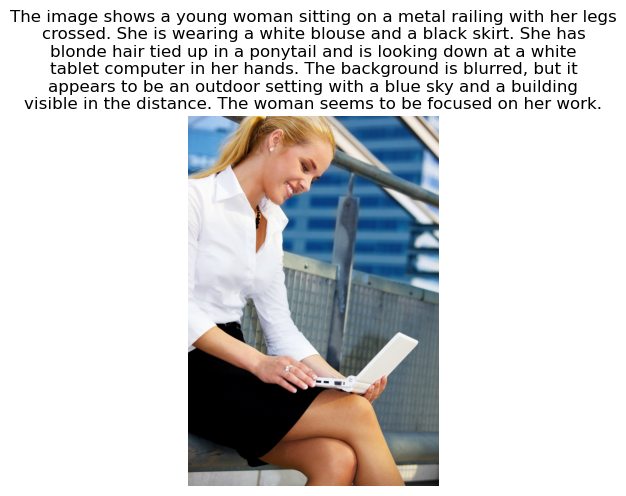

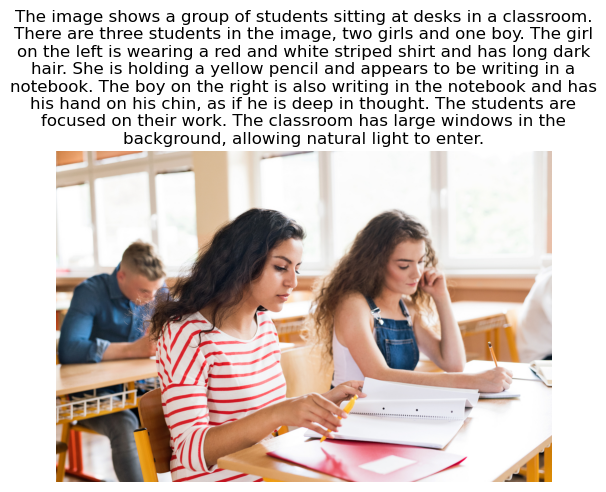

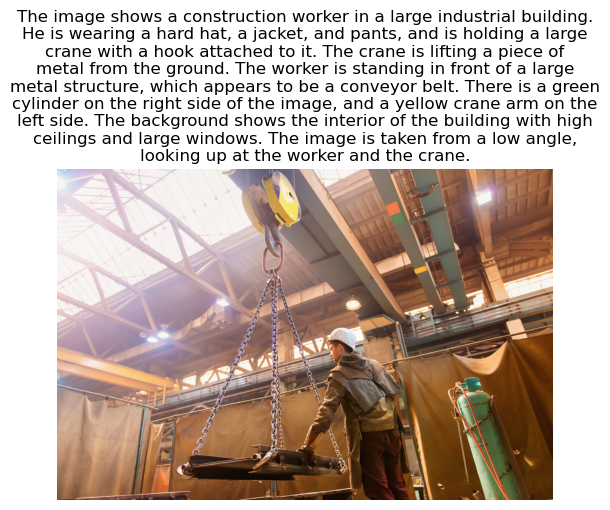

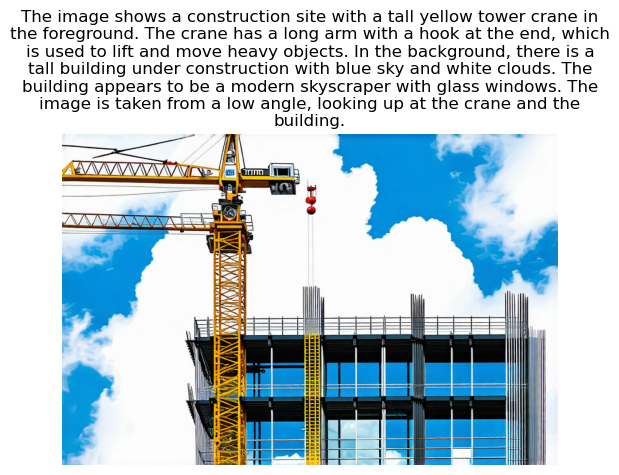

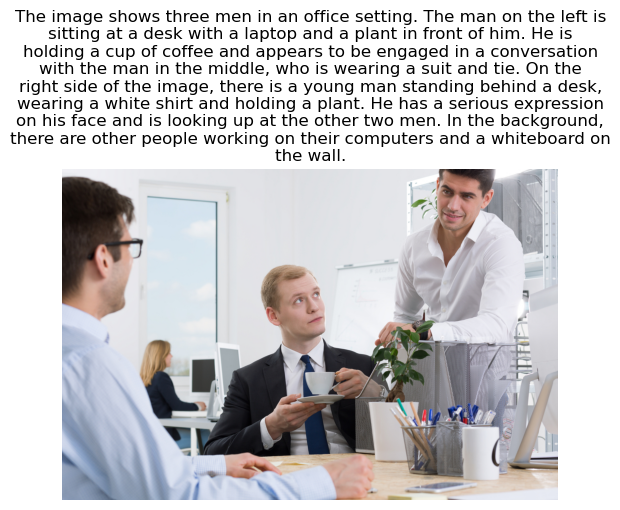

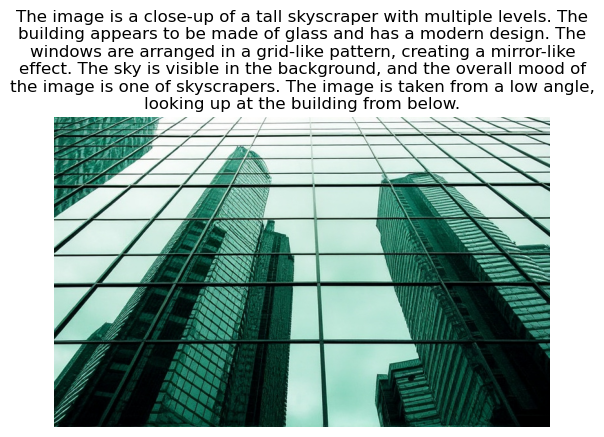

In [30]:
for i in range(len(word_emb_output_df)):
    image_name = word_emb_output_df.iloc[i].file_name
    image_tag =  word_emb_output_df.iloc[i].florence_long
    image_filename = '../sample_imagesv2/'+image_name
    img = mpimg.imread(image_filename)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(image_tag)
    plt.show()

<h2>Storing the solution</h2>

In [44]:
import dill as pickle

with open('models/image_recommender_model_florence_long_word2vectfidf_files.pkl', 'wb') as f:
    pickle.dump(wordemb_image_recommender, f)
    pickle.dump(tagged_sample_df, f)
    pickle.dump(text_preprocess, f) #word embedder
    #pickle.dump(word2vec_model, f) #word embedder
    pickle.dump(X_emb, f) #word embedding matrix
    pickle.dump(text2emb, f) #text to sentence embedding

In [45]:
with open('models/image_recommender_model_florence_long_word2vectfidf_files.pkl', 'rb') as f:
    system_image_recommender = pickle.load(f)
    sys_tagged_sample_df = pickle.load(f)
    text_preprocess = pickle.load(f)
    #sys_word2vec_model = pickle.load(f)
    sys_X_emb = pickle.load(f)
    sys_text2emb = pickle.load(f)

In [46]:
tagger = 'florence_long'
text_in = 'people'
output_df = system_image_recommender(sys_tagged_sample_df,tagger,[],sys_X_emb,text_in,sys_text2emb,thr_=0.0,top_n=10)
output_df

file_name  \
433  db73de18bf0245dc8fd11f4a631bf550.jpg   
26   0bac186a8b494b0ab51e5188d003bab5.jpg   
377  cd1e6f09865742ef969159e627d70944.jpg   
286  b5c0570e1a2e4dd7b988dc67c5218180.jpg   
114  2c0280d40e2a4ab2bbf083115318afe0.jpg   
123  f2d49d4c48704b99986f3e5147e1db08.jpg   
110  a52da730290b44e99d74a70aac660638.jpg   
234  4ed6d54305c54036bdb6573cb82b0b93.jpg   
400  60ed358a1b5546d89ff421521eb38b70.jpg   
285  292f73146bce402c802fa7aef758fa5b.jpg   

                                         florence_long       sim  
433  The image shows a group of five young people s...  0.384425  
26   The image shows a group of four people, two me...  0.374569  
377  The image shows a group of four young people, ...  0.362142  
286  The image shows a group of four people sitting...  0.358774  
114  The image shows three men in an office setting...  0.357536  
123  The image shows a group of five young people w...  0.353859  
110  The image shows a man and a woman standing beh...  0.340827  
234  The image shows three young women sitting at a...  0.338284  
400  The image shows a group of four people, two me...  0.325346  
285  The image shows a doctor and an elderly man in...  0.323529